# QUORA QUESTIONS PAIRS (PREDICTING DUPLICATE PAIRS USING NLP)
#### The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning.
#### https://www.kaggle.com/competitions/quora-question-pairs/

## -> WORKFLOW
#### 1. `TEXT PRE PROCESSING` - TOKENIZATION, STOP WORDS REMOVAL, STEMMING.
#### 2. MAKING WORD VECTORS WITH `WORD2VEC`.
#### 3. CONVERTING COLUMNS TO `VECTORS`.
#### 4. GENERATING `CUSTOM FEATURES`.
#### 5. PERFORMING `OVERSAMPLING` DUE TO CLASS IMBALANCE.
#### 6. TRAINING `RANDOM FOREST CLASSIFIER`, `XG BOOST CLASSIFIER`, `RNN` AND `LSTM` MODELS.
#### 7. PERFORMANCE ANALYSIS
#### 8. `INFERENCE` ON TEST

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import zipfile

In [20]:
import gensim
from gensim.models import Word2Vec,KeyedVectors
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

## EXTRACTING DATA

In [21]:
zip_files = ['/kaggle/input/quora-question-pairs/train.csv.zip', 
             '/kaggle/input/quora-question-pairs/test.csv.zip', 
             '/kaggle/input/quora-question-pairs/sample_submission.csv.zip']

destination_directory = '/kaggle/working/'

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_directory)

print("Extraction completed.")

Extraction completed.


In [22]:
data = pd.read_csv("/kaggle/working/train.csv")
data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [23]:
data["is_duplicate"].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

In [24]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [25]:
data.dropna(inplace = True)

## MAKING CORPUS AND CLEANING THE TEXT

In [26]:
corpus = data['question1'].tolist() + data['question2'].tolist()

story = []
for sent in tqdm(corpus):
    story.append(simple_preprocess(sent))


100%|██████████| 808574/808574 [00:17<00:00, 46088.57it/s]


In [27]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

stemmer = PorterStemmer()
def process_word_list(word_list):
    meaningful_words = [
        stemmer.stem(word)  # Apply stemming
        for word in word_list
        if word.lower() not in stopwords.words("english")  # Remove stopwords
    ]
    return meaningful_words

cleaned_story = [process_word_list(sublist) for sublist in tqdm(story)]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



100%|██████████| 808574/808574 [21:16<00:00, 633.65it/s]


## WORD2VEC 


In [28]:
word2vec_model = gensim.models.Word2Vec(window = 5, min_count = 2, vector_size=30)
word2vec_model.build_vocab(cleaned_story)
word2vec_model.train(cleaned_story, 
            total_examples = word2vec_model.corpus_count, 
            epochs = word2vec_model.epochs)

(20498886, 21715385)

In [29]:
data["Ques1_Cleaned"] = cleaned_story[:len(data)]
data["Ques2_Cleaned"] = cleaned_story[len(data):]

In [30]:
sample_data = data.copy() # INITIALLY USED FOR TAKING SAMPLES OUT OF MAIN DATA
sample_data.reset_index(inplace = True, drop = True)

## GENERATING CUSTOM FEATURES USING TEXT BLOB
* AVG WORD LENGTH
* WORD COUNT
* AVG SENTENCE LENGTH
* FOG INDEX
* COMPLEX WORD COUNT

In [31]:
from textblob import TextBlob

def text_analysis(word_list):
    # Join the list of words into a text string
    text = " ".join(word_list)

    # Create a TextBlob object
    blob = TextBlob(text)

    # Sentiment Analysis
    polarity_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity

    # Word Metrics
    word_count = len(word_list)
    average_word_length = sum(len(word) for word in word_list) / word_count

    # Sentence Metrics
    sentence_count = len(blob.sentences)
    average_sentence_length = word_count / sentence_count

    # FOG Index
    complex_word_count = len([word for word in word_list if len(word) > 3])
    fog_index = 0.4 * (average_sentence_length + complex_word_count / word_count)
    
    return np.array([average_word_length, word_count, average_sentence_length, fog_index, complex_word_count])

## CONVERTING TEXT COLUMN INTO VECTORS

In [32]:
vec1 = np.zeros((len(sample_data), 30))
vec2 = np.zeros((len(sample_data), 30))
other_features = np.zeros((len(sample_data), 10))

for i in tqdm(range(len(sample_data))):
    
    text1 = sample_data["Ques1_Cleaned"][i]
    text2 = sample_data["Ques2_Cleaned"][i]
    
    if len(text1) != 0:
        vec1[i] = (sum([word2vec_model.wv[word] for word in text1 if word in word2vec_model.wv.index_to_key]) / len(text1))
        blob1 = text_analysis(text1)
    else:
        vec1[i] = np.zeros((30,))
        blob1 = np.zeros((5,))
    if len(text2) != 0:
        vec2[i] = (sum([word2vec_model.wv[word] for word in text2 if word in word2vec_model.wv.index_to_key]) / len(text2))
        blob2 = text_analysis(text2)
    else:
        vec2i = np.zeros((30,))
        blob2 = np.zeros((5,))
    other_features[i] = np.concatenate([blob1, blob2])


100%|██████████| 404287/404287 [11:35<00:00, 581.62it/s]


In [33]:
sample_data = pd.concat([sample_data, 
                        pd.DataFrame(vec1, columns = np.arange(0, 30)),
                        pd.DataFrame(vec2, columns = np.arange(30, 60)),
                        pd.DataFrame(other_features, columns = np.arange(60, 70))], axis = 1)
sample_data

,id,qid1,qid2,question1,question2,is_duplicate,Ques1_Cleaned,Ques2_Cleaned,0,1,...,60,61,62,63,64,65,66,67,68,69
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",-1.159381,-0.586994,...,4.857143,7.0,7.0,3.200000,7.0,4.833333,6.0,6.0,2.800000,6.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[stori, kohinoor, koh, noor, diamond]","[would, happen, indian, govern, stole, kohinoo...",-0.093272,-0.708282,...,5.400000,5.0,5.0,2.320000,4.0,5.400000,10.0,10.0,4.360000,9.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]",0.178854,-0.743040,...,5.500000,6.0,6.0,2.666667,4.0,5.200000,5.0,5.0,2.320000,4.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mental, lone, solv]","[find, remaind, math, math, divid]",0.944953,-1.927504,...,4.666667,3.0,3.0,1.600000,3.0,4.800000,5.0,5.0,2.400000,5.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]",0.138335,-0.279766,...,4.800000,10.0,10.0,4.320000,8.0,4.800000,5.0,5.0,2.400000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404282,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,"[mani, keyword, racket, program, languag, late...","[mani, keyword, perl, program, languag, latest...",0.781076,1.234625,...,6.285714,7.0,7.0,3.200000,7.0,6.000000,7.0,7.0,3.200000,7.0
404283,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,"[believ, life, death]","[true, life, death]",2.170387,-2.154618,...,5.000000,3.0,3.0,1.600000,3.0,4.333333,3.0,3.0,1.600000,3.0
404284,404287,537928,537929,What is one coin?,What's this coin?,0,"[one, coin]",[coin],1.907229,-0.379139,...,3.500000,2.0,2.0,1.000000,1.0,4.000000,1.0,1.0,0.800000,1.0
404285,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,"[approx, annual, cost, live, studi, uic, chica...","[littl, hairfal, problem, want, use, hair, sty...",0.143278,-0.215860,...,5.333333,9.0,9.0,3.955556,8.0,4.692308,13.0,13.0,5.476923,9.0


## OVERSAMPLING

In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
xresampled, yresampled = smote.fit_resample(sample_data.iloc[:,8:], sample_data["is_duplicate"])
xresampled.shape, yresampled.shape

((510048, 70), (510048,))

## MODELING

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
xtrain, xtest, ytrain, ytest = train_test_split(xresampled, yresampled, test_size = 0.2)
xtrain.shape, ytrain.shape

((408038, 70), (408038,))

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(xtrain, ytrain)
rf_model.score(xtest, ytest)

0.8554847563964317

In [37]:
import xgboost as xg
xg_model = xg.XGBClassifier()
xg_model.fit(xtrain, ytrain)
xg_model.score(xtest, ytest)

0.8053720223507499

## PERFORMANCE ANALYSIS

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

ypred1 = rf_model.predict(xtest)
ypred2 = xg_model.predict(xtest)
conf_matrix1 = confusion_matrix(ytest, ypred1)
conf_matrix2 = confusion_matrix(ytest, ypred2)

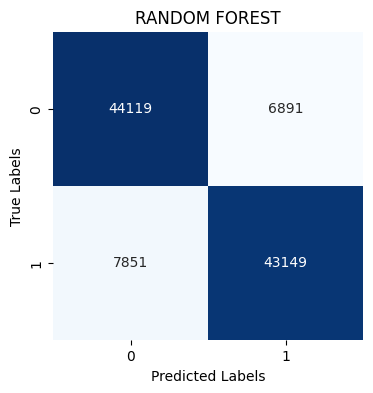

In [39]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('RANDOM FOREST')
plt.show()

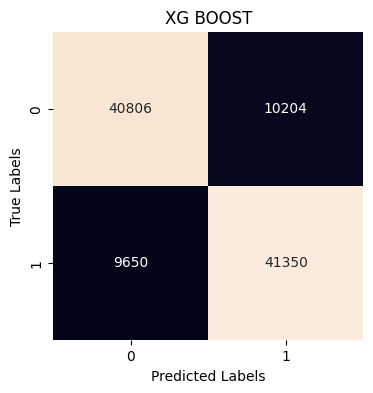

In [40]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XG BOOST')
plt.show()

### PREDICTION ON TEST SET

In [ ]:
# test_data = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv")
# sample = pd.read_csv("/kaggle/working/sample_submission.csv")
# test_data

In [ ]:
# outs = []
# for k in tqdm(range(len(test_data))):
#     sample1 = test_data["question1"][k]
#     sample2 = test_data["question2"][k]
#     inf_data = inference(sample1, sample2)
#     outs.append(rf_model.predict(inf_data)[0])
# sample["Predictions"] = outs
# sample.drop("is_duplicate", axis = 1)
# sample

# RNN - DL APPROACH

## MAKING TOKENIZED SEQUENCES

In [43]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
xresampled_dl, yresampled_dl = ros.fit_resample(data.iloc[:,3:5], data["is_duplicate"])
xresampled_dl.shape, yresampled_dl.shape

((510048, 2), (510048,))

In [44]:
que1 = np.array(xresampled_dl['question1'].tolist())
que2 = np.array(xresampled_dl['question2'].tolist())

docx = []
for i in tqdm(range(len(que1))):
    docx.append(que1[i] + " " + que2[i])


100%|██████████| 510048/510048 [00:04<00:00, 125822.56it/s]


In [45]:
lengths = []
for sent in tqdm(docx):
    lengths.append(len(sent.split()))


100%|██████████| 510048/510048 [00:00<00:00, 528605.58it/s]


<Axes: ylabel='Density'>

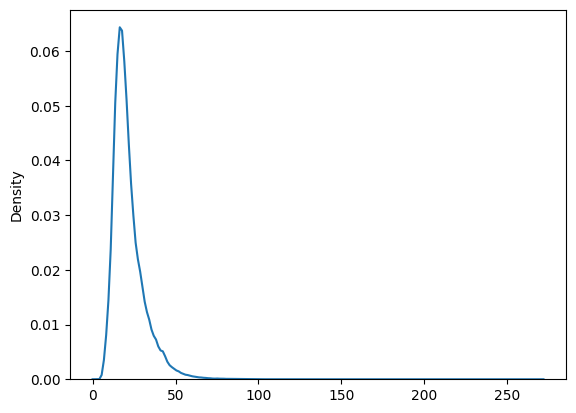

In [46]:
sns.kdeplot(lengths) # TO SEE, AROUND WHICH NUMBER THE MOST SENTENCE LENGHTS LIES

In [47]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 35)

 86%|████████▌ | 697211/808574 [1:16:27<12:12, 151.97it/s]


## MODEL ARCHITECTURE

In [48]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(sequences.max()+1, output_dim = 30, input_length = 35))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 30)            2867910   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2016      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,869,959
Trainable params: 2,869,959
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])
history = model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)

Epoch 1/20
409/409 [==============================] - 20s 44ms/step - loss: 0.5275 - accuracy: 0.7411 - val_loss: 0.5798 - val_accuracy: 0.6804
Epoch 2/20
409/409 [==============================] - 18s 43ms/step - loss: 0.4588 - accuracy: 0.7825 - val_loss: 0.5768 - val_accuracy: 0.7021
Epoch 3/20
409/409 [==============================] - 18s 43ms/step - loss: 0.4194 - accuracy: 0.8027 - val_loss: 0.4472 - val_accuracy: 0.8262
Epoch 4/20
409/409 [==============================] - 17s 42ms/step - loss: 0.3856 - accuracy: 0.8190 - val_loss: 0.4496 - val_accuracy: 0.8070
Epoch 5/20
409/409 [==============================] - 18s 43ms/step - loss: 0.3520 - accuracy: 0.8368 - val_loss: 0.3365 - val_accuracy: 0.8736
Epoch 6/20
409/409 [==============================] - 18s 44ms/step - loss: 0.3164 - accuracy: 0.8556 - val_loss: 0.5558 - val_accuracy: 0.7114
Epoch 7/20
409/409 [==============================] - 18s 43ms/step - loss: 0.2840 - accuracy: 0.8727 - val_loss: 0.5100 - val_accuracy:

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

max_seq_length = 35
vocab_size = sequences.max() + 1

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_length))
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           9559700   
                                                                 
 bidirectional (Bidirectiona  (None, 35, 128)          84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 35, 128)           0         
                                                                 
 dense_1 (Dense)             (None, 35, 1)             129       
                                                                 
Total params: 9,644,309
Trainable params: 9,644,309
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = lstm_model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)

Epoch 1/20
409/409 [==============================] - 208s 498ms/step - loss: 0.5275 - accuracy: 0.7381 - val_loss: 0.7233 - val_accuracy: 0.5569
Epoch 2/20
409/409 [==============================] - 204s 499ms/step - loss: 0.4659 - accuracy: 0.7766 - val_loss: 0.6095 - val_accuracy: 0.6616
Epoch 3/20
409/409 [==============================] - 214s 524ms/step - loss: 0.4307 - accuracy: 0.7920 - val_loss: 0.5800 - val_accuracy: 0.6780
Epoch 4/20
409/409 [==============================] - 207s 506ms/step - loss: 0.4002 - accuracy: 0.8042 - val_loss: 0.5075 - val_accuracy: 0.7251
Epoch 5/20
409/409 [==============================] - 205s 502ms/step - loss: 0.3711 - accuracy: 0.8181 - val_loss: 0.4295 - val_accuracy: 0.7895
Epoch 6/20
 84/409 [=====>........................] - ETA: 2:34 - loss: 0.3358 - accuracy: 0.8376

## TEST SET

In [ ]:
# test_data = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv")
# sample = pd.read_csv("/kaggle/working/sample_submission.csv")
# test_data

In [ ]:
# outs = []
# for k in tqdm(range(len(test_data))):
#     sample1 = test_data["question1"][k]
#     sample2 = test_data["question2"][k]
#     inf_data = inference_dl(sample1, sample2)
#     out = lstm_model.predict(inf_data, verbose = 0)
#     out = tf.squeeze(out)
#     out = 1 if np.mean(out) >= 0.5 else 0
# #     if out > 0.5:
# #         out = 1
# #     else:
# #         out = 0
#     outs.append(out)
# sample["Predictions"] = outs
# sample.drop("is_duplicate", axis = 1)
# sample

# THANKYOU